In [1]:
#pip install -r requirements.txt

# Pacote

In [1]:
import pandas as pd
import chardet
import glob
from unidecode import unidecode
import os
import Levenshtein as lev
import csv

# Configuração do pandas
pd.set_option('display.max_columns', None)

# Dicionário com as bibliotecas e seus métodos de versão
libraries = {
    "pandas": pd.__version__,                   # Versão do pandas
    "chardet": chardet.__version__,             # Versão do chardet
    "glob": "Built-in library (Python Standard Library)",  # glob não tem versão separada
    "unidecode": unidecode.__name__,         # Versão do unidecode
    "os": "Built-in library (Python Standard Library)",    # os não tem versão separada
    "Levenshtein": lev.__version__,             # Versão do Levenshtein
    "csv": "Built-in library (Python Standard Library)"    # csv não tem versão separada
}

# Exibindo as versões das bibliotecas
for lib, version in libraries.items():
    print(f"{lib}: {version}")


pandas: 2.1.4
chardet: 5.2.0
glob: Built-in library (Python Standard Library)
unidecode: unidecode_expect_ascii
os: Built-in library (Python Standard Library)
Levenshtein: 0.23.0
csv: Built-in library (Python Standard Library)


# Funções

In [2]:
def detect_encoding(file_pattern_or_path, num_bytes=10000):
    """
    Detecta a codificação do arquivo ou arquivos fornecidos.
    
    Parâmetros:
        file_pattern_or_path (str): Caminho ou padrão do arquivo para detecção.
        num_bytes (int, opcional): Número de bytes para ler para a detecção. Padrão é 10000.
    
    Retorna:
        dict: Dicionário com caminho do arquivo como chave e codificação detectada como valor.
    """
    
    # Encontrar arquivos que correspondem ao padrão ou caminho fornecido.
    files = glob.glob(file_pattern_or_path)
    encodings = {}

    # Iterar sobre cada arquivo encontrado.
    for file_path in files:
        # Abrir arquivo em modo binário e ler os primeiros 'num_bytes' bytes.
        with open(file_path, 'rb') as f:
            rawdata = f.read(num_bytes)
            # Detectar a codificação do fragmento lido e armazenar no dicionário.
            encodings[file_path] = chardet.detect(rawdata)["encoding"]
    
    return encodings

def is_delayed(row):
    """
    Determina se um voo está atrasado ou pontual com base na diferença de tempo entre a partida prevista e a real.

    Parâmetros:
    row (pd.Series): Uma linha de um DataFrame que contém informações de partida do voo.

    Retorna:
    str: "Atrasado" se o voo estiver atrasado por mais de 15 minutos, caso contrário "Pontual".
    """
    # Calcula a diferença de tempo entre a partida real e a prevista.
    delta = row['Partida Real'] - row['Partida Prevista']
    # Retorna "Atrasado" se a diferença for maior que 15 minutos, senão "Pontual".
    return "Atrasado" if delta > pd.Timedelta(minutes=15) else "Pontual"

def padronizar_nome_coluna(coluna):
    """
    Padroniza o nome de uma coluna removendo acentos, transformando em minúsculas e substituindo espaços, hífens, 
    parênteses, pontos, vírgulas, porcentagens e barras por underscores ou removendo-os. Remove underscores duplicados.

    Parâmetros:
    coluna (str): Nome da coluna a ser padronizado.

    Retorna:
    str: Nome da coluna padronizado.
    """
    from unidecode import unidecode

    # Remover acentos do nome da coluna.
    coluna = unidecode(coluna)
    # Transformar todas as letras em minúsculas.
    coluna = coluna.lower()
    # Substituir espaços, hífens, parênteses, pontos, vírgulas, porcentagens, barras e barras invertidas por underscores ou removendo-os.
    coluna = coluna.replace(' ', '_').replace('-', '_').replace('(', '_').replace(')', '_').replace('.', '_').replace(',', '_').replace('%', 'pcnt').replace('/', '').replace('\\', '')
    # Substituir underscores duplicados por um único underscore.
    while '__' in coluna:
        coluna = coluna.replace('__', '_')

    return coluna

def calculate_time_delta(row, start_col, end_col):
    """
    Calcula a diferença de tempo entre duas colunas de um DataFrame.

    Parâmetros:
    row (pd.Series): Uma linha do DataFrame.
    start_col (str): Nome da coluna com o tempo inicial.
    end_col (str): Nome da coluna com o tempo final.

    Retorna:
    pd.Timedelta: Diferença de tempo entre 'start_col' e 'end_col'.
    """
    # Extrai os tempos iniciais e finais das colunas especificadas.
    start_time = row[start_col]
    end_time = row[end_col]
    
    # Verifica se algum dos tempos é NaT (Not a Time) e retorna 0 se verdadeiro.
    if pd.isna(start_time) or pd.isna(end_time):
        return 0
    
    # Calcula e retorna a diferença absoluta de tempo entre os dois tempos.
    delta = abs(end_time - start_time)
    return delta

def calculate_time_int(row, start_col, end_col):
    """
    Calcula a diferença de tempo em minutos entre duas colunas de um DataFrame.

    Parâmetros:
    row (pd.Series): Uma linha do DataFrame.
    start_col (str): Nome da coluna com o tempo inicial.
    end_col (str): Nome da coluna com o tempo final.

    Retorna:
    int: Diferença de tempo em minutos entre 'start_col' e 'end_col'.
    """
    # Extrai os tempos iniciais e finais das colunas especificadas.
    start_time = row[start_col]
    end_time = row[end_col]
    
    # Verifica se algum dos tempos é NaT (Not a Time) e retorna 0 se verdadeiro.
    if pd.isna(start_time) or pd.isna(end_time):
        return 0
    
    # Calcula a diferença de tempo, converte para segundos e depois para minutos.
    delta = abs(end_time - start_time)
    return int(delta.total_seconds() / 60)

def encontrar_coluna_similar(coluna, colunas_padrao, limiar=8):
    """
    Encontra a coluna mais similar a um dado nome de coluna, baseado em uma medida de distância.

    Args:
    coluna (str): Nome da coluna a ser comparada.
    colunas_padrao (list): Lista de nomes de colunas padrão para comparação.
    limiar (int, optional): Limiar de distância para considerar uma coluna similar. Default é 8.

    Etapas:
    1. Iterar sobre cada coluna padrão.
    2. Calcular a distância de Levenshtein entre a coluna e cada coluna padrão.
    3. Se a distância for menor ou igual ao limiar, retornar a coluna padrão correspondente.
    4. Se nenhuma coluna padrão satisfizer o critério, retornar o nome da coluna original.

    Returns:
    str: O nome da coluna mais similar dentre as colunas padrão, ou o próprio nome da coluna se nenhuma for suficientemente similar.
    """
     # Itera sobre cada coluna padrão na lista fornecida.
    for padrao in colunas_padrao:
        # Calcula a distância de Levenshtein entre a coluna e a coluna padrão atual.
        # A função lev.distance() é assumida como uma função predefinida ou importada para calcular esta distância.
        if lev.distance(coluna, padrao) <= limiar:
            # Se a distância for menor ou igual ao limiar, retorna a coluna padrão como correspondente.
            return padrao
    # Se nenhuma coluna padrão corresponder dentro do limiar, retorna o nome da coluna original.
    return coluna

# Função para detectar o delimitador mais adequado
def detectar_delimitador(filename, encoding='utf-8', num_lines=10):
    """
    Detecta o delimitador mais adequado para um arquivo CSV.

    Args:
    filename (str): Nome do arquivo a ser analisado.
    encoding (str, optional): Codificação do arquivo. Default é 'utf-8'.
    num_lines (int, optional): Número de linhas a serem lidas para a detecção do delimitador. Default é 10.

    Etapas:
    1. Definir uma lista de delimitadores possíveis.
    2. Ler as primeiras linhas do arquivo, testando cada delimitador possível.
    3. Identificar o delimitador que resulta no maior número de campos (colunas) por linha.
    4. Retornar o delimitador que maximiza o número de campos.

    Returns:
    str: O delimitador mais adequado encontrado no arquivo. Se nenhum delimitador adequado for encontrado, retorna None.
    """
    # Define uma lista de delimitadores possíveis para testar no arquivo.
    delimitadores_possiveis = [',', ';', '\t', '|']
    # Inicializa variáveis para armazenar o delimitador com o máximo de campos e o número máximo de campos.
    max_delimiter = None
    max_fields = 1

    # Abre o arquivo com o nome e codificação especificados.
    with open(filename, 'r', encoding=encoding) as file:
        # Testa cada delimitador possível.
        for delimiter in delimitadores_possiveis:
            # Retorna ao início do arquivo antes de testar um novo delimitador.
            file.seek(0)
            # Cria um leitor CSV com o delimitador atual.
            reader = csv.reader(file, delimiter=delimiter)
            # Itera sobre as linhas do arquivo até o limite especificado.
            for i, row in enumerate(reader):
                # Interrompe a leitura após um determinado número de linhas.
                if i >= num_lines:
                    break
                # Atualiza o delimitador e o número máximo de campos se este delimitador resultar em mais campos.
                if len(row) > max_fields:
                    max_fields = len(row)
                    max_delimiter = delimiter

    # Retorna o delimitador que resultou no maior número de campos por linha.
    return max_delimiter

# Carregando dados

In [148]:
df_aeroportos[df_aeroportos["País"] == "BRASIL"]

,Sigla OACI,Descrição,Cidade,UF,País,Continente
0,1AON,OUROLANDIA DO NORTE,OURILANDIA DO NORTE,PA,BRASIL,AMERICA DO SUL
1,2NHT,HOTEL TRANSAMÉRICA,UNA,BA,BRASIL,AMERICA DO SUL
2,6ASO,SORRISO,SORRISO,MT,BRASIL,AMERICA DO SUL
312,SBAA,CONCEIÇÃO DO ARAGUAIA,CONCEIÇÃO DO ARAGUAIA,PA,BRASIL,AMERICA DO SUL
313,SBAE,BAURU/AREALVA,AREALVA,SP,BRASIL,AMERICA DO SUL
...,...,...,...,...,...,...
780,SWXV,XAVANTINA,NOVA XAVANTINA,MT,BRASIL,AMERICA DO SUL
781,SWYK,FAZENDA ILHA CAMARGO,POCONÉ,MT,BRASIL,AMERICA DO SUL
782,SWYN,PRAINHA,APUÍ,AM,BRASIL,AMERICA DO SUL
783,SWYY,AEROPORTO FAZENDA NOVA VIENA,NOVA XAVANTINA,MT,BRASIL,AMERICA DO SUL


In [146]:
df_aeroportos_2

,codigo_oaci,ciad,nome,municipio,uf,altitude,latgeopoint,longeopoint,latitude_aero,longitude_aero
0,SDZG,CE0008,PEDRO TEIXEIRA CASTELO REGIONAL TAUA,TAUA,CEARA,"444,0",-5.933333,-40.297500,-5.933333,-40.297500
1,SDIG,SP0038,IBITINGA,IBITINGA,SAO PAULO,"542,0",-21.747222,-48.855833,-21.747222,-48.855833
2,SBVT,ES0001,EURICO DE AGUIAR SALLES,VITORIA,ESPIRITO SANTO,"3,0",-20.258056,-40.286389,-20.258056,-40.286389
3,SNJK,BA0047,JEQUIE,JEQUIE,BAHIA,"197,0",-13.877778,-40.071389,-13.877778,-40.071389
4,SSKU,SC0016,LAURO ANTONIO DA COSTA,CURITIBANOS,SANTA CATARINA,"978,0",-27.287222,-50.603889,-27.287222,-50.603889
...,...,...,...,...,...,...,...,...,...,...
493,SNKF,MG0071,DAS BANDEIRINHAS,CONSELHEIRO LAFAIETE,MINAS GERAIS,"1057,0",-20.738611,-43.797500,-20.738611,-43.797500
494,SSRS,MA0008,BARREIRINHAS,BARREIRINHAS,MARANHAO,"12,0",-2.756667,-42.803333,-2.756667,-42.803333
495,SWWA,GO0012,PORANGATU,PORANGATU,GOIAS,"366,0",-13.404444,-49.157222,-13.404444,-49.157222
496,SWKT,GO0015,CATALAO,CATALAO,GOIAS,"802,0",-18.216944,-47.899444,-18.216944,-47.899444


In [8]:
# --- Carregamento dos Dados dos Aeroportos ---
# Definindo o caminho para o arquivo CSV dos glossários de aeródromos.
file_path = "C:/Users/pedro/Documents/Curso de pos graduação de EST/DADOS AVIACAO/dados_complementares/glossario_de_aerodromo.csv"

# Detectando a codificação do arquivo de aeródromos para assegurar a leitura correta dos dados.
file_encodings = detect_encoding(file_path)

# Obtendo a codificação detectada para o arquivo específico.
encoding = file_encodings[file_path]

# Lendo o arquivo CSV com a codificação apropriada.
# A codificação detectada é usada para lidar com possíveis caracteres especiais nos dados.
df_aeroportos = pd.read_csv(file_path, sep=',', encoding=encoding)  # A codificação pode variar (ex: 'iso-8859-1', 'cp1252'), dependendo do arquivo.


# --- Carregamento dos Dados das Companhias Aéreas ---
# Definindo o caminho para o arquivo CSV dos glossários de empresas aéreas.
file_path = "C:/Users/pedro/Documents/Curso de pos graduação de EST/DADOS AVIACAO/dados_complementares/glossario_de_empresas_aereas.csv"

# Detectando a codificação do arquivo das empresas aéreas.
file_encodings = detect_encoding(file_path)

# Obtendo a codificação detectada para este arquivo específico.
encoding = file_encodings[file_path]

# Lendo o arquivo CSV com a codificação apropriada.
# Novamente, a codificação detectada é essencial para lidar com caracteres especiais.
df_cia_aerea = pd.read_csv(file_path, sep=',', encoding=encoding)  # A codificação pode variar, semelhante ao arquivo de aeródromos.

# --- Carregamento dos Dados das Companhias Aéreas ---
# Definindo o caminho para o arquivo CSV com algumas informações de aeroportos.
file_path = "C:/Users/pedro/Documents/Curso de pos graduação de EST/DADOS AVIACAO/dados_tratados/dados_aeroportos_tratado.csv"

# Detectando a codificação do arquivo.
file_encodings = detect_encoding(file_path)

# Obtendo a codificação detectada para este arquivo específico.
encoding = file_encodings[file_path]

# Lendo o arquivo CSV com a codificação apropriada.
# Novamente, a codificação detectada é essencial para lidar com caracteres especiais.
df_aeroportos_2 = pd.read_csv(file_path, sep=',', encoding=encoding)  # A codificação pode variar, semelhante ao arquivo de aeródromos.

In [36]:
mapeamento_colunas = {
    'Código Autorização (DI)': 'Codigo DI',
    'cd_di': 'Codigo DI',
    'ICAO Empresa Aerea': 'ICAO Empresa Aérea',
    'sg_empresa_icao': 'ICAO Empresa Aérea',
    'Número Voo': 'Número Voo',
    'NUmero Voo': 'Número Voo',
    'Numero Voo': 'Número Voo',
    'nr_voo': 'Número Voo',
    'Código Tipo Linha': 'Código Tipo Linha',
    'Codigo Tipo Linha': 'Código Tipo Linha',
    'cd_tipo_linha': 'Código Tipo Linha',
    'ICAO Aeródromo Origem': 'ICAO Aeródromo Origem',
    'ICAO Aerodromo Origem': 'ICAO Aeródromo Origem',
    'sg_icao_origem': 'ICAO Aeródromo Origem',
    'ICAO Aeródromo Destino': 'ICAO Aeródromo Destino',
    'ICAO Aerodromo Destino': 'ICAO Aeródromo Destino',
    'sg_icao_destino': 'ICAO Aeródromo Destino',
    'Partida Prevista': 'Partida Prevista',
    'dt_partida_prevista': 'Partida Prevista',
    'Partida Real': 'Partida Real',
    'Código DI': 'Codigo DI',   
    'Data Partida Real': 'Partida Real',
    'Data Chegada Real': 'Chegada Real',
    'Data Partida Prevista': 'Partida Prevista',
    'Data Chegada Prevista': 'Chegada Prevista',
    'dt_partida_real': 'Partida Real',
    'Chegada Prevista': 'Chegada Prevista',
    'dt_chegada_prevista': 'Chegada Prevista',
    'Chegada Real': 'Chegada Real',
    'dt_chegada_real': 'Chegada Real',
    'Situação Voo': 'Situação Voo',
    'Situacao Voo': 'Situação Voo',
    'situacao': 'Situação Voo',
    'Código Justificativa': 'Código Justificativa',
    'Codigo Justificativa': 'Código Justificativa',
    'cd_justificativa': 'Código Justificativa',
    'ICAO Aer—dromo Origem': 'ICAO Aeródromo Origem',
    'ICAO Aer—dromo Destino': 'ICAO Aeródromo Destino',
    'Sigla ICAO Aeroporto Origem': 'ICAO Aeródromo Origem',
    'Sigla ICAO Aeroporto Destino': 'ICAO Aeródromo Destino',
    'Sigla ICAO Empresa Aérea': 'ICAO Empresa Aérea',
}

# Colunas padrão esperadas
colunas_esperadas = [
    'ICAO Empresa Aérea', 'Número Voo', 'Código Tipo Linha',
    'ICAO Aeródromo Origem', 'ICAO Aeródromo Destino', 'Partida Prevista', 'Partida Real',
    'Chegada Prevista', 'Chegada Real', 'Situação Voo', 'Código Justificativa', 'Codigo DI'
]

# Definindo o caminho para os arquivos CSV do ano de 2019.
file_path = "2022/*.csv"

# Detectando a codificação dos arquivos CSV
file_encodings = detect_encoding(file_path)
codificacoes_comuns = ['utf-8', 'latin1', 'ISO-8859-1', 'ascii','utf-32','utf-16']
# Processamento dos arquivos CSV
df_list = []
for filename in glob.glob(file_path):
    print(f"Carregando arquivo: {filename}")
    for encoding in codificacoes_comuns:
        try:
            delimitador = detectar_delimitador(filename, encoding=encoding)
            df = pd.read_csv(filename, encoding=encoding, sep=delimitador, low_memory=False, index_col=None)

            # Renomear colunas com base no mapeamento
            df.rename(columns=mapeamento_colunas, inplace=True, errors='ignore')

            # Manter apenas as colunas esperadas que existem no DataFrame
            colunas_existentes = [col for col in colunas_esperadas if col in df.columns]
            df = df[colunas_existentes]

            df_list.append(df)
            print(f"Arquivo {filename} carregado com sucesso usando a codificação {encoding}.")
            break
        except UnicodeDecodeError as e:
            print(f"Erro de decodificação com a codificação {encoding} no arquivo {filename}: {e}")
        except Exception as e:
            print(f"Erro ao carregar o arquivo {filename}: {e}")
            break

# Concatenando todos os DataFrames em um único DataFrame para análise combinada.
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print("Todos os arquivos CSV foram carregados com sucesso.")
else:
    print("Nenhum arquivo CSV foi encontrado ou carregado.")

Carregando arquivo: 2022\vra-01_2022.csv
Arquivo 2022\vra-01_2022.csv carregado com sucesso usando a codificação utf-8.
Carregando arquivo: 2022\vra-02_2022.csv
Erro de decodificação com a codificação utf-8 no arquivo 2022\vra-02_2022.csv: 'utf-8' codec can't decode byte 0xe9 in position 20: invalid continuation byte
Arquivo 2022\vra-02_2022.csv carregado com sucesso usando a codificação latin1.
Carregando arquivo: 2022\vra-03_2022.csv
Erro de decodificação com a codificação utf-8 no arquivo 2022\vra-03_2022.csv: 'utf-8' codec can't decode byte 0xe9 in position 20: invalid continuation byte
Arquivo 2022\vra-03_2022.csv carregado com sucesso usando a codificação latin1.
Carregando arquivo: 2022\vra-04_2022.csv
Arquivo 2022\vra-04_2022.csv carregado com sucesso usando a codificação utf-8.
Carregando arquivo: 2022\vra-05_2022.csv
Arquivo 2022\vra-05_2022.csv carregado com sucesso usando a codificação utf-8.
Carregando arquivo: 2022\vra-06_2022.csv
Erro de decodificação com a codificação u

In [37]:
df_2022 = combined_df

In [38]:
df_2022

,ICAO Empresa Aérea,Número Voo,Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Codigo DI,Situação Voo
0,AAL,904,I,SBGL,KMIA,01/01/2022 00:05,NaN,01/01/2022 08:50,NaN,0,NaN
1,AAL,905,I,KMIA,SBGL,01/01/2022 22:00,NaN,02/01/2022 06:20,NaN,0,NaN
2,AAL,906,I,SBGR,KMIA,01/01/2022 00:05,NaN,01/01/2022 08:40,NaN,0,NaN
3,AAL,929,I,KMIA,SBGR,01/01/2022 22:00,NaN,02/01/2022 06:20,NaN,0,NaN
4,AAL,930,I,SBGR,KMIA,01/01/2022 22:30,NaN,02/01/2022 06:55,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
875269,VVC,461,X,SBGR,SKRG,NaN,30/12/2022 20:00,NaN,31/12/2022 06:21,2,REALIZADO
875270,VVC,460,I,SBGR,SKRG,31/12/2022 05:20,NaN,31/12/2022 11:38,NaN,0,CANCELADO
875271,VVC,460,X,SKRG,SBGR,NaN,31/12/2022 07:24,NaN,31/12/2022 09:25,2,REALIZADO
875272,VVC,461,I,SKRG,SBGR,31/12/2022 22:00,NaN,01/01/2023 04:30,NaN,0,CANCELADO


In [39]:
df_2023

,ICAO Empresa Aérea,Número Voo,Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Codigo DI
0,AAL,904,I,SBGL,KMIA,01/01/2023 00:05,31/12/2022 23:59,01/01/2023 08:37,01/01/2023 08:12,REALIZADO,0
1,AAL,905,I,KMIA,SBGL,01/01/2023 21:45,01/01/2023 00:56,02/01/2023 06:20,01/01/2023 09:03,REALIZADO,0
2,AAL,906,I,SBGR,KMIA,01/01/2023 00:00,31/12/2022 23:54,01/01/2023 06:30,01/01/2023 07:52,REALIZADO,0
3,AAL,929,I,KMIA,SBGR,01/01/2023 21:45,01/01/2023 21:51,02/01/2023 06:20,02/01/2023 06:33,REALIZADO,0
4,AAL,930,I,SBGR,KMIA,01/01/2023 22:00,01/01/2023 22:27,02/01/2023 06:55,02/01/2023 06:33,REALIZADO,0
...,...,...,...,...,...,...,...,...,...,...,...
983876,VTU,1986,I,MTPP,SBBV,26/12/2023 07:00,NaN,26/12/2023 12:00,NaN,NÃO INFORMADO,2
983877,VTU,1986,I,MTPP,SBBV,27/12/2023 10:00,NaN,27/12/2023 14:00,NaN,NÃO INFORMADO,2
983878,VTU,1986,I,SBBV,SVMI,27/12/2023 14:50,NaN,27/12/2023 17:30,NaN,NÃO INFORMADO,2
983879,WFL,9753,I,LEMD,SBSV,11/12/2023 11:00,NaN,11/12/2023 20:10,NaN,NÃO INFORMADO,2


In [42]:
dfs = [df_2022,df_2023,df_2024]

In [44]:
df_full = pd.concat(dfs, ignore_index=True)

In [45]:
df_full

,ICAO Empresa Aérea,Número Voo,Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Codigo DI,Situação Voo
0,AAL,904,I,SBGL,KMIA,01/01/2022 00:05,NaN,01/01/2022 08:50,NaN,0,NaN
1,AAL,905,I,KMIA,SBGL,01/01/2022 22:00,NaN,02/01/2022 06:20,NaN,0,NaN
2,AAL,906,I,SBGR,KMIA,01/01/2022 00:05,NaN,01/01/2022 08:40,NaN,0,NaN
3,AAL,929,I,KMIA,SBGR,01/01/2022 22:00,NaN,02/01/2022 06:20,NaN,0,NaN
4,AAL,930,I,SBGR,KMIA,01/01/2022 22:30,NaN,02/01/2022 06:55,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2847024,VCV,4931,X,SBEG,SVPR,NaN,12/12/2024 17:29,NaN,12/12/2024 19:40,7,REALIZADO
2847025,VCV,4930,I,SVPR,SBEG,19/12/2024 13:30,19/12/2024 13:44,19/12/2024 15:40,19/12/2024 15:53,7,REALIZADO
2847026,VCV,4931,I,SBEG,SVPR,19/12/2024 16:40,19/12/2024 17:04,19/12/2024 18:50,19/12/2024 19:15,7,REALIZADO
2847027,VCV,4930,I,SVPR,SBEG,26/12/2024 13:30,26/12/2024 14:07,26/12/2024 15:40,26/12/2024 16:19,7,REALIZADO


In [48]:
df = df_full.copy()

## Dicionário de dados
| Campo                         | Descrição                                                                                                   |
|-------------------------------|-------------------------------------------------------------------------------------------------------------|
| Sigla ICAO Empresa Aérea      | Sigla/Designador ICAO Empresa Aérea                                                                         |
| Número Voo                    | Numeração do voo                                                                                            |
| Código DI                     | Caractere usado para identificar o Dígito Identificador (DI) para cada etapa de voo                         |
| Código Tipo Linha             | Caractere usado para identificar o Tipo de Linha realizada para cada etapa de voo                           |
| Sigla ICAO Aeroporto Origem   | Sigla/Designador ICAO Aeroporto de Origem                                                                   |
| Sigla ICAO Aeroporto Destino  | Sigla/Designador ICAO Aeroporto de Destino                                                                  |
| Partida Prevista              | Data e horário da partida prevista informada pela empresa aérea, em horário de Brasília                      |
| Partida Real                  | Data e horário da partida realizada informada pela empresa aérea, em horário de Brasília                     |
| Chegada Prevista              | Data e horário da chegada prevista informada pela empresa aérea, em horário de Brasília                      |
| Chegada Real                  | Data e horário da chegada realizada, informada pela empresa aérea, em horário de Brasília                    |
| Situação do voo               | Campo informando a situação do voo: realizado, cancelado ou não informado.                                  |


# Tratamento de dados

## Join com as tabelas complementares

In [49]:
# Preparando DataFrames de Aeroportos para Mesclagem com o DataFrame Principal.

# Criando cópias do DataFrame de aeroportos para uso separado como origem e destino.
df_aeroportos_origem = df_aeroportos.copy()
df_aeroportos_destino = df_aeroportos.copy()

# Renomeando as colunas do DataFrame de aeroportos origem.
# Isso é feito para evitar conflitos de nomes ao mesclar com o DataFrame principal.
# Cada nome de coluna é acrescido de '_origem' para indicar que se refere ao aeroporto de origem do voo.
df_aeroportos_origem.rename(columns={col: col + '_origem' for col in df_aeroportos_origem.columns}, inplace=True)

# Renomeando as colunas do DataFrame de aeroportos destino de forma similar.
# Aqui, '_destino' é acrescido para indicar que as colunas se referem ao aeroporto de destino.
df_aeroportos_destino.rename(columns={col: col + '_destino' for col in df_aeroportos_destino.columns}, inplace=True)

# Mesclando o DataFrame principal com o DataFrame de companhias aéreas.
# A mesclagem é feita com base na coluna 'ICAO Empresa Aérea' do DataFrame principal
# e na coluna 'Sigla OACI' do DataFrame das companhias aéreas.
# A opção 'inner' assegura que apenas os registros presentes em ambos os DataFrames sejam mantidos.
df = pd.merge(df, df_cia_aerea, left_on='ICAO Empresa Aérea', right_on='Sigla OACI', how='inner')

# Mesclando o DataFrame resultante com o DataFrame de aeroportos origem.
# A mesclagem utiliza 'ICAO Aeródromo Origem' do DataFrame principal e 'Sigla OACI_origem' do DataFrame de aeroportos origem.
df = pd.merge(df, df_aeroportos_origem, left_on='ICAO Aeródromo Origem', right_on='Sigla OACI_origem', how='inner')

# Mesclando o DataFrame resultante com o DataFrame de aeroportos destino.
# Similar à etapa anterior, mas agora usando 'ICAO Aeródromo Destino' e 'Sigla OACI_destino'.
df = pd.merge(df, df_aeroportos_destino, left_on='ICAO Aeródromo Destino', right_on='Sigla OACI_destino', how='inner')


## Filtro de cia aerea 

In [17]:
# Filtrando o DataFrame para incluir apenas voos das empresas aéreas específicas.

# Definindo a lista de códigos ICAO das empresas aéreas desejadas para o filtro.
valores_filtrar = ['GLO', 'AZU', 'TAM']

# Filtrando o DataFrame para manter apenas as linhas onde 'ICAO Empresa Aérea' corresponde aos valores na lista de filtro.
df = df[df['ICAO Empresa Aérea'].isin(valores_filtrar)]

## Datas

In [51]:
# Convertendo colunas de datas e horas de partidas e chegadas para o formato datetime.

# As seguintes colunas são convertidas para o tipo datetime usando o formato especificado '%d/%m/%Y %H:%M':
# Conversão com tratamento de datas inválidas (transforma em NaT)
df['Partida Prevista'] = pd.to_datetime(df['Partida Prevista'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Partida Real'] = pd.to_datetime(df['Partida Real'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Chegada Prevista'] = pd.to_datetime(df['Chegada Prevista'], format='%d/%m/%Y %H:%M', errors='coerce')
df['Chegada Real'] = pd.to_datetime(df['Chegada Real'], format='%d/%m/%Y %H:%M', errors='coerce')


# Aplicando a função 'is_delayed' em cada linha para determinar se o voo está atrasado ou pontual.
# O resultado é armazenado na nova coluna 'Status do Voo'.
df['Status do Voo'] = df.apply(is_delayed, axis=1)

### Criação de colunas com delta

In [52]:
# Aplicando a função para calcular o delta de tempo
df['Delta Tempo Partida delta'] = df.apply(calculate_time_delta, axis=1, start_col='Partida Prevista', end_col='Partida Real')
df['Delta Tempo Chegada delta'] = df.apply(calculate_time_delta, axis=1, start_col='Chegada Prevista', end_col='Chegada Real')

# Aplicando a função para calcular o delta de tempo
df['Delta Tempo Partida int'] = df.apply(calculate_time_int, axis=1, start_col='Partida Prevista', end_col='Partida Real')
df['Delta Tempo Chegada int'] = df.apply(calculate_time_int, axis=1, start_col='Chegada Prevista', end_col='Chegada Real')

## Seleção de colunas

In [53]:
df

,ICAO Empresa Aérea,Número Voo,Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Codigo DI,Situação Voo,Sigla OACI,Nome Empresas,Nacional ou Estrangeira,Sigla OACI_origem,Descrição_origem,Cidade_origem,UF_origem,País_origem,Continente_origem,Sigla OACI_destino,Descrição_destino,Cidade_destino,UF_destino,País_destino,Continente_destino,Status do Voo,Delta Tempo Partida delta,Delta Tempo Chegada delta,Delta Tempo Partida int,Delta Tempo Chegada int
0,AAL,904,I,SBGL,KMIA,2022-01-01 00:05:00,NaT,2022-01-01 08:50:00,NaT,0,NaN,AAL,AMERICAN AIRLINES INC,ESTRANGEIRA,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,RIO DE JANEIRO,RJ,BRASIL,AMERICA DO SUL,KMIA,MIAMI INTERNATIONAL AIRPORT,MIAMI,NaN,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0
1,AAL,904,I,SBGL,KMIA,2022-01-02 00:05:00,NaT,2022-01-02 08:50:00,NaT,0,NaN,AAL,AMERICAN AIRLINES INC,ESTRANGEIRA,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,RIO DE JANEIRO,RJ,BRASIL,AMERICA DO SUL,KMIA,MIAMI INTERNATIONAL AIRPORT,MIAMI,NaN,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0
2,AAL,904,I,SBGL,KMIA,2022-01-03 00:05:00,NaT,2022-01-03 08:50:00,NaT,0,NaN,AAL,AMERICAN AIRLINES INC,ESTRANGEIRA,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,RIO DE JANEIRO,RJ,BRASIL,AMERICA DO SUL,KMIA,MIAMI INTERNATIONAL AIRPORT,MIAMI,NaN,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0
3,AAL,904,I,SBGL,KMIA,2022-01-04 00:05:00,NaT,2022-01-04 08:40:00,NaT,0,NaN,AAL,AMERICAN AIRLINES INC,ESTRANGEIRA,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,RIO DE JANEIRO,RJ,BRASIL,AMERICA DO SUL,KMIA,MIAMI INTERNATIONAL AIRPORT,MIAMI,NaN,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0
4,AAL,904,I,SBGL,KMIA,2022-01-05 00:05:00,NaT,2022-01-05 08:40:00,NaT,0,NaN,AAL,AMERICAN AIRLINES INC,ESTRANGEIRA,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,RIO DE JANEIRO,RJ,BRASIL,AMERICA DO SUL,KMIA,MIAMI INTERNATIONAL AIRPORT,MIAMI,NaN,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660015,QTR,8315,G,OTHH,OOMS,2023-11-27 23:10:00,NaT,2023-11-28 00:45:00,NaT,0,CANCELADO,QTR,QATAR AIRWAYS,ESTRANGEIRA,OTHH,HAMAD INTERNATIONAL AIRPORT,NaN,NaN,QATAR,ASIA,OOMS,MUSCAT INTERNATIONAL AIRPORT,MUSCAT,NaN,OMA,ASIA,Pontual,0,0,0,0
2660016,QTR,8915,G,OTHH,OOMS,2023-12-05 00:15:00,NaT,2023-12-05 01:50:00,NaT,0,CANCELADO,QTR,QATAR AIRWAYS,ESTRANGEIRA,OTHH,HAMAD INTERNATIONAL AIRPORT,NaN,NaN,QATAR,ASIA,OOMS,MUSCAT INTERNATIONAL AIRPORT,MUSCAT,NaN,OMA,ASIA,Pontual,0,0,0,0
2660017,QTR,8915,G,OTHH,OOMS,2023-12-12 00:15:00,NaT,2023-12-12 01:50:00,NaT,0,CANCELADO,QTR,QATAR AIRWAYS,ESTRANGEIRA,OTHH,HAMAD INTERNATIONAL AIRPORT,NaN,NaN,QATAR,ASIA,OOMS,MUSCAT INTERNATIONAL AIRPORT,MUSCAT,NaN,OMA,ASIA,Pontual,0,0,0,0
2660018,THY,0003,I,LTBA,LTFJ,2024-11-06 16:30:00,NaT,2024-11-06 17:00:00,NaT,2,CANCELADO,THY,TURKISH AIRLINES INC.,ESTRANGEIRA,LTBA,ATATÃœRK INTERNATIONAL AIRPORT,ISTANBUL/ATATURK,NaN,TURQUIA,EUROPA,LTFJ,SABIHA GÃ–KÃ‡EN INTERNATIONAL AIRPORT,ISTAMBUL,NaN,TURQUIA,EUROPA,Pontual,0,0,0,0


In [54]:
df= df[['Nome Empresas','Número Voo', 'Codigo DI','ICAO Aeródromo Origem', 'ICAO Aeródromo Destino',
 'Código Tipo Linha', 'Partida Prevista', 'Partida Real',
 'Chegada Prevista', 'Chegada Real', 'Situação Voo',
 'Descrição_origem', 'País_origem', 'Continente_origem',
 'Descrição_destino', 'País_destino', 'Continente_destino',
 'Status do Voo', 'Delta Tempo Partida delta', 'Delta Tempo Chegada delta',
 'Delta Tempo Partida int', 'Delta Tempo Chegada int', 'Cidade_origem',
 'UF_origem', 'Cidade_destino', 'UF_destino']]

## Removendo caracteres especiais e espaço do nome das colunas

In [55]:
# Aplicar a função a cada nome de coluna
df.columns = [padronizar_nome_coluna(col) for col in df.columns]

# Adiação de colunas mês, dia do mês e dia da semana

In [65]:
df['ano'] = df['chegada_prevista'].dt.year

C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\3853504322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ano'] = df['chegada_prevista'].dt.year


In [56]:
# Extração de componentes de data das colunas de partida e chegada.

# As seguintes operações são realizadas para extrair informações específicas das datas de partida:
# 1. 'mes_partida': Extração do mês da 'partida_prevista'.
# 2. 'dia_semana_partida': Extração do dia da semana da 'partida_prevista' (0 = Segunda-feira, 6 = Domingo).
# 3. 'dia_mes_partida': Extração do dia do mês da 'partida_prevista'.
df['mes_partida'] = df['partida_prevista'].dt.month
df['dia_semana_partida'] = df['partida_prevista'].dt.dayofweek
df['dia_mes_partida'] = df['partida_prevista'].dt.day
df['hora_partida'] = df['partida_prevista'].dt.hour
# Nota: As mesmas informações são extraídas para 'chegada_prevista', mas há um erro no código;
# 'partida_prevista' está sendo usada ao invés de 'chegada_prevista'.
# As variáveis 'mes_chegada', 'dia_semana_chegada', e 'dia_mes_chegada' devem ser ajustadas para usar 'chegada_prevista'.
df['mes_chegada'] = df['chegada_prevista'].dt.month
df['dia_semana_chegada'] = df['chegada_prevista'].dt.dayofweek
df['dia_mes_chegada'] = df['chegada_prevista'].dt.day
df['hora_chegada'] = df['chegada_prevista'].dt.hour


C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\3335256749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mes_partida'] = df['partida_prevista'].dt.month
C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\3335256749.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dia_semana_partida'] = df['partida_prevista'].dt.dayofweek
C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\3335256749.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

# Adicionando informações adicionais do Aeroporto

In [57]:
# Preparando DataFrames de Aeroportos para Mesclagem com o DataFrame Principal.

# Criando cópias do DataFrame de aeroportos para uso separado como origem e destino.
df_aeroportos_origem = df_aeroportos_2.copy()
df_aeroportos_destino = df_aeroportos_2.copy()

# Renomeando as colunas do DataFrame de aeroportos origem.
# Isso é feito para evitar conflitos de nomes ao mesclar com o DataFrame principal.
# Cada nome de coluna é acrescido de '_origem' para indicar que se refere ao aeroporto de origem do voo.
df_aeroportos_origem.rename(columns={col: col + '_origem' for col in df_aeroportos_origem.columns}, inplace=True)

# Renomeando as colunas do DataFrame de aeroportos destino de forma similar.
# Aqui, '_destino' é acrescido para indicar que as colunas se referem ao aeroporto de destino.
df_aeroportos_destino.rename(columns={col: col + '_destino' for col in df_aeroportos_destino.columns}, inplace=True)

# Mesclando o DataFrame resultante com o DataFrame de aeroportos origem.
# A mesclagem utiliza 'ICAO Aeródromo Origem' do DataFrame principal e 'Sigla OACI_origem' do DataFrame de aeroportos origem.
df = pd.merge(df, df_aeroportos_origem, left_on='icao_aerodromo_origem', right_on='codigo_oaci_origem', how='left')

# Mesclando o DataFrame resultante com o DataFrame de aeroportos destino.
# Similar à etapa anterior, mas agora usando 'ICAO Aeródromo Destino' e 'Sigla OACI_destino'.
df = pd.merge(df, df_aeroportos_destino, left_on='icao_aerodromo_destino', right_on='codigo_oaci_destino', how='left')

In [58]:
df

,nome_empresas,numero_voo,codigo_di,icao_aerodromo_origem,icao_aerodromo_destino,codigo_tipo_linha,partida_prevista,partida_real,chegada_prevista,chegada_real,situacao_voo,descricao_origem,pais_origem,continente_origem,descricao_destino,pais_destino,continente_destino,status_do_voo,delta_tempo_partida_delta,delta_tempo_chegada_delta,delta_tempo_partida_int,delta_tempo_chegada_int,cidade_origem,uf_origem_x,cidade_destino,uf_destino_x,mes_partida,dia_semana_partida,dia_mes_partida,hora_partida,mes_chegada,dia_semana_chegada,dia_mes_chegada,hora_chegada,codigo_oaci_origem,ciad_origem,nome_origem,municipio_origem,uf_origem_y,altitude_origem,latgeopoint_origem,longeopoint_origem,latitude_aero_origem,longitude_aero_origem,codigo_oaci_destino,ciad_destino,nome_destino,municipio_destino,uf_destino_y,altitude_destino,latgeopoint_destino,longeopoint_destino,latitude_aero_destino,longitude_aero_destino
0,AMERICAN AIRLINES INC,904,0,SBGL,KMIA,I,2022-01-01 00:05:00,NaT,2022-01-01 08:50:00,NaT,NaN,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,BRASIL,AMERICA DO SUL,MIAMI INTERNATIONAL AIRPORT,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0,RIO DE JANEIRO,RJ,MIAMI,NaN,1.0,5.0,1.0,0.0,1.0,5.0,1.0,8.0,SBGL,RJ0001,RIO DE JANEIRO/GALEAO - ANTONIO CARLOS JOBIM,RIO DE JANEIRO,RIO DE JANEIRO,"9,0",-22.81,-43.250556,-22.81,-43.250556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMERICAN AIRLINES INC,904,0,SBGL,KMIA,I,2022-01-02 00:05:00,NaT,2022-01-02 08:50:00,NaT,NaN,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,BRASIL,AMERICA DO SUL,MIAMI INTERNATIONAL AIRPORT,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0,RIO DE JANEIRO,RJ,MIAMI,NaN,1.0,6.0,2.0,0.0,1.0,6.0,2.0,8.0,SBGL,RJ0001,RIO DE JANEIRO/GALEAO - ANTONIO CARLOS JOBIM,RIO DE JANEIRO,RIO DE JANEIRO,"9,0",-22.81,-43.250556,-22.81,-43.250556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AMERICAN AIRLINES INC,904,0,SBGL,KMIA,I,2022-01-03 00:05:00,NaT,2022-01-03 08:50:00,NaT,NaN,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,BRASIL,AMERICA DO SUL,MIAMI INTERNATIONAL AIRPORT,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0,RIO DE JANEIRO,RJ,MIAMI,NaN,1.0,0.0,3.0,0.0,1.0,0.0,3.0,8.0,SBGL,RJ0001,RIO DE JANEIRO/GALEAO - ANTONIO CARLOS JOBIM,RIO DE JANEIRO,RIO DE JANEIRO,"9,0",-22.81,-43.250556,-22.81,-43.250556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AMERICAN AIRLINES INC,904,0,SBGL,KMIA,I,2022-01-04 00:05:00,NaT,2022-01-04 08:40:00,NaT,NaN,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,BRASIL,AMERICA DO SUL,MIAMI INTERNATIONAL AIRPORT,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0,RIO DE JANEIRO,RJ,MIAMI,NaN,1.0,1.0,4.0,0.0,1.0,1.0,4.0,8.0,SBGL,RJ0001,RIO DE JANEIRO/GALEAO - ANTONIO CARLOS JOBIM,RIO DE JANEIRO,RIO DE JANEIRO,"9,0",-22.81,-43.250556,-22.81,-43.250556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AMERICAN AIRLINES INC,904,0,SBGL,KMIA,I,2022-01-05 00:05:00,NaT,2022-01-05 08:40:00,NaT,NaN,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO/GALE...,BRASIL,AMERICA DO SUL,MIAMI INTERNATIONAL AIRPORT,ESTADOS UNIDOS DA AMERICA,AMERICA DO NORTE,Pontual,0,0,0,0,RIO DE JANEIRO,RJ,MIAMI,NaN,1.0,2.0,5.0,0.0,1.0,2.0,5.0,8.0,SBGL,RJ0001,RIO DE JANEIRO/GALEAO - ANTONIO CARLOS JOBIM,RIO DE JANEIRO,RIO DE JANEIRO,"9,0",-22.81,-43.250556,-22.81,-43.250556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660015,QATAR AIRWAYS,8315,0,OTHH,OOMS,G,2023-11-27 23:10:00,NaT,2023-11-28 00:45:00,NaT,CANCELADO,HAMAD INTERNATIONAL AIRPORT,QATAR,ASIA,MUSCAT INTERNATIONAL AIRPORT,OMA,ASIA,Pontual,0,0,0,0,NaN,NaN,MUSCAT,NaN,11.0,0.0,27.0,23.0,11.0,1.0,28.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2660016,QATAR AIRWAYS,8915,0,OTHH,OOMS,G,2023-12-05 00:15:00,NaT,2023-12-05 01:50:00,NaT,CANCELADO,HAMAD INTERNATIONAL AIRPORT,QATAR,ASIA

# Padronização e seleção de colunas

In [59]:
df =  df[['nome_empresas', 'numero_voo', 'codigo_di', 'codigo_tipo_linha',
 'partida_prevista', 'partida_real', 'chegada_prevista',
 'chegada_real', 'situacao_voo', 'descricao_origem', 'pais_origem',
 'continente_origem', 'descricao_destino', 'pais_destino',
 'continente_destino', 'status_do_voo', 'delta_tempo_partida_delta',
 'delta_tempo_chegada_delta', 'delta_tempo_partida_int', 'delta_tempo_chegada_int',
 'cidade_origem', 'uf_origem_x', 'cidade_destino', 'uf_destino_x', 'mes_partida',
 'dia_semana_partida', 'dia_mes_partida', 'hora_partida',
 'mes_chegada', 'dia_semana_chegada', 'dia_mes_chegada',
 'hora_chegada',  'altitude_origem', 'latgeopoint_origem',
 'longeopoint_origem', 'latitude_aero_origem', 'longitude_aero_origem',
 'altitude_destino', 'latgeopoint_destino', 'longeopoint_destino',
 'latitude_aero_destino', 'longitude_aero_destino']]

In [60]:
def clean_name(name):
    # Remove content inside parentheses
    name = pd.Series(name).replace(r'\(.*?\)', '', regex=True).str.strip()

    # Remove accents and special characters
    return name.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()

In [61]:
# Applying the cleaning function to the 'uf' column
df['cidade_origem'] = clean_name(df['cidade_origem'])
df['cidade_destino'] = clean_name(df['cidade_destino'])
df['descricao_origem'] = clean_name(df['descricao_origem'])
df['descricao_destino'] = clean_name(df['descricao_destino'])

C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\2003219343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cidade_origem'] = clean_name(df['cidade_origem'])
C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\2003219343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cidade_destino'] = clean_name(df['cidade_destino'])
C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\2003219343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

# Criando coluna com as principais rotas

In [62]:
# Criação da variavel rota (aeroporto origem + aeroporto destino). Observar as rotas mais problemas de atraso e cancelamento
df['rota'] = df['descricao_origem'] + " -> " + df['descricao_destino']

C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\1053866737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rota'] = df['descricao_origem'] + " -> " + df['descricao_destino']


# Salvando os dados tratatos para realizar o join com dados meteorologicos

In [3]:
# Definir o caminho do diretório e do arquivo CSV
diretorio = 'dados_tratados'
nome_arquivo = 'historico_voo_tratados_2022_23_24.csv'
caminho_completo = os.path.join(diretorio, nome_arquivo)

# Verificar se o diretório existe. Se não, criar o diretório
if not os.path.exists(diretorio):
    os.makedirs(diretorio)

# Salvar o DataFrame no arquivo CSV
df.to_csv(caminho_completo, index=False)

NameError: name 'df' is not defined

In [9]:
df['codigo_di'] = df['codigo_di'].apply(lambda x: str(x))
df['numero_voo'] = df['numero_voo'].apply(lambda x: str(x))
df.to_parquet('df_tcc_22_23_24.parquet', engine='pyarrow', compression='snappy')

In [5]:
df = pd.read_csv(caminho_completo)

C:\Users\pedro\AppData\Local\Temp\ipykernel_20244\4215046468.py:1: DtypeWarning: Columns (1,2,21,23,32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_completo)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660020 entries, 0 to 2660019
Data columns (total 43 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   nome_empresas              object 
 1   numero_voo                 object 
 2   codigo_di                  object 
 3   codigo_tipo_linha          object 
 4   partida_prevista           object 
 5   partida_real               object 
 6   chegada_prevista           object 
 7   chegada_real               object 
 8   situacao_voo               object 
 9   descricao_origem           object 
 10  pais_origem                object 
 11  continente_origem          object 
 12  descricao_destino          object 
 13  pais_destino               object 
 14  continente_destino         object 
 15  status_do_voo              object 
 16  delta_tempo_partida_delta  object 
 17  delta_tempo_chegada_delta  object 
 18  delta_tempo_partida_int    int64  
 19  delta_tempo_chegada_int    int64  
 20  ci

In [108]:
df = df[df['ano'] != 2025]

In [132]:
total_voos_ano = df_realizados.groupby('ano').size().reset_index(name='total_voos_ano')
total_voos_ano

In [134]:
530083/840741

0.6304950038121133

In [135]:
1-0.6304950038121133

0.3695049961878867

C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\279661169.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ano', y='total_voos_ano', data=total_voos_ano, palette='Blues_d')


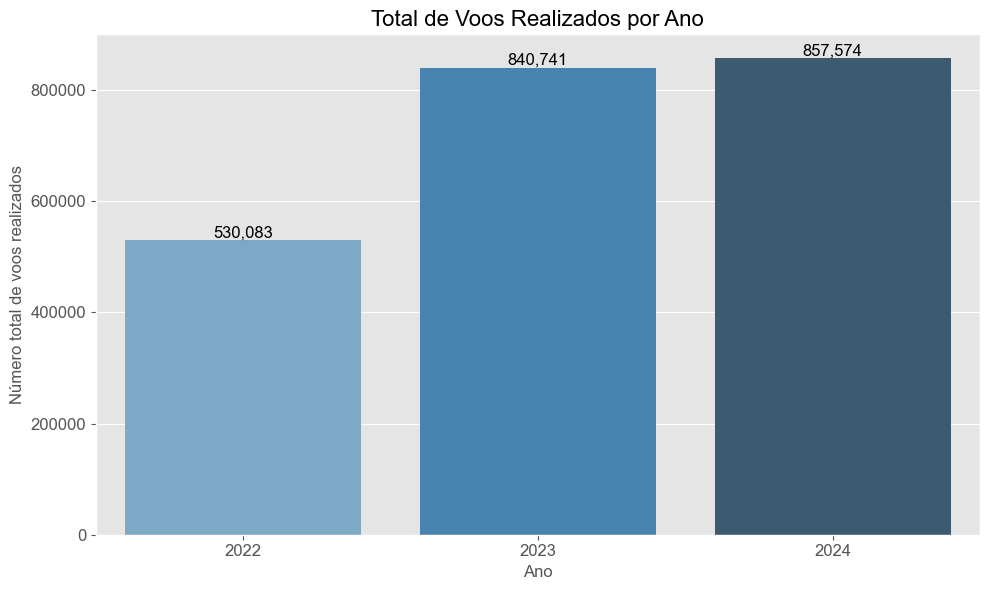

In [136]:
# Dados
total_voos_ano = df_realizados.groupby('ano').size().reset_index(name='total_voos_ano')

# Gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ano', y='total_voos_ano', data=total_voos_ano, palette='Blues_d')

# Labels nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

# Títulos e estética
plt.title('Total de Voos Realizados por Ano', fontsize=16)
plt.ylabel('Número total de voos realizados')
plt.xlabel('Ano')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [133]:
total_voos_ano

,ano,total_voos_ano
0,2022,530083
1,2023,840741
2,2024,857574


In [ ]:
df_realizados['nome_empresas'].value_counts(normalize=True) * 100

In [138]:
colors = {
    'GOL': '#E36729',
    'AZUL': '#18B4E9',
    'TAM': '#ED1650',
    'MAP LINHAS AEREAS': '#2ca02c',
    'PASSAREDO': '#ff7f0e',
    'TAP AIR PORTUGAL': '#1f77b4',
    'LAN CHILE': '#9467bd',
    'AVIANCA': '#d62728',
    'AMERICAN AIRLINES INC': '#bcbd22',
    'COPA -COMPANIA PANAMENA DE AVIACION': '#17becf',
    'Outros': '#8c564b',
    'UNITED AIRLINES': '#7f7f7f',
    'AIR FRANCE': '#aec7e8',
    'AEROLINEAS ARGENTINAS': '#ffbb78',
    'DELTA AIRLINES': '#98df8a',
    'QATAR AIRWAYS': '#c49c94'
}

C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\2388548158.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_top10_outros.index, y=df_top10_outros.values, palette=colors)


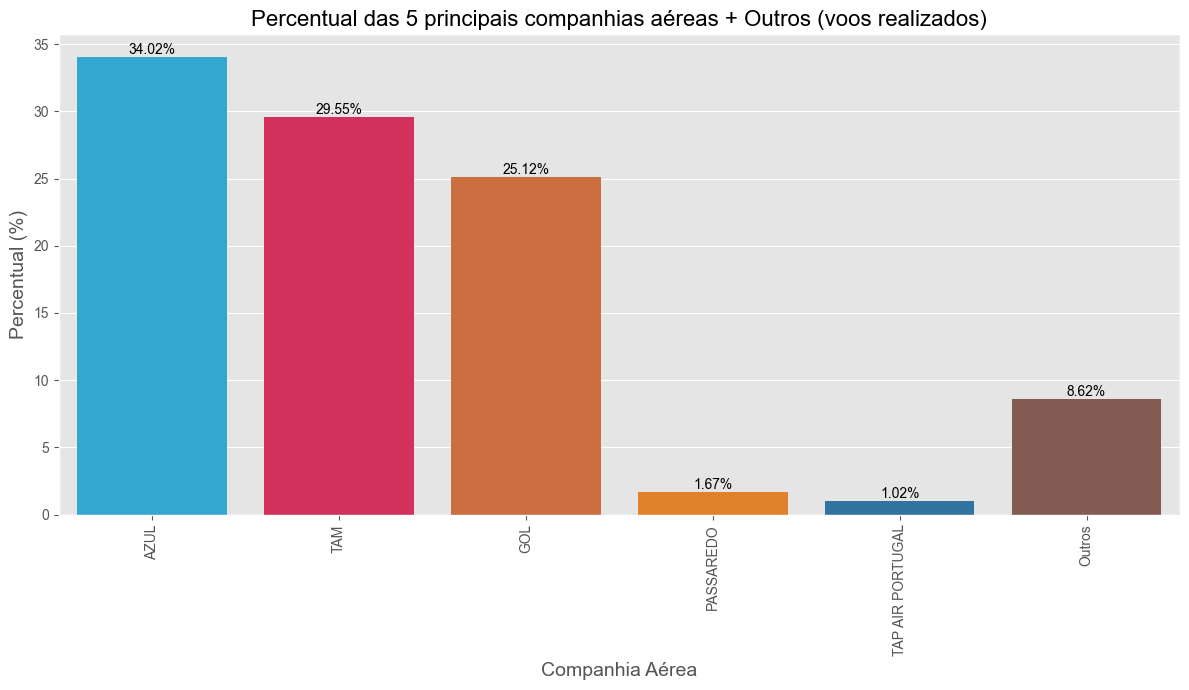

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remover linhas com 'ano' nulo para evitar problemas futuros
df = df.dropna(subset=['ano'])
df['ano'] = df['ano'].astype(int)

# Filtra voos realizados
df_realizados = df[df['situacao_voo'] == 'REALIZADO']

# Calcula percentual de participação por empresa
percentual_empresas = df_realizados['nome_empresas'].value_counts(normalize=True) * 100

# Seleciona as 10 primeiras empresas e agrupa as restantes em 'Outros'
top_10 = percentual_empresas.head(5)
outros = percentual_empresas.iloc[5:].sum()

# Cria um novo DataFrame com 'Outros' incluído
df_top10_outros = pd.concat([top_10, pd.Series({'Outros': outros})])

# Gráfico de barras
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=df_top10_outros.index, y=df_top10_outros.values, palette=colors)

# Labels com percentual nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('Percentual das 5 principais companhias aéreas + Outros (voos realizados)', fontsize=16)
plt.ylabel('Percentual (%)', fontsize=14)
plt.xlabel('Companhia Aérea', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [121]:
dic = {
    'font.sans-serif': ['Arial'],  # Fonte
    'font.family': ['Arial']}
sns.set_style(rc=dic)
plt.style.use('ggplot')

# Análise Visual da Frequência e Status dos Voos por Empresa Aérea.

# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Definindo a ordem específica das companhias aéreas e suas respectivas cores para os gráficos.
ordem = ['AZUL','GOL', 'TAM']
colors = {
    'GOL': '#E36729',
    'AZUL': '#18B4E9',
    'TAM': '#ED1650',
    'MAP LINHAS AEREAS': '#2ca02c',
    'PASSAREDO': '#ff7f0e',
    'Outros': '#8c564b'
}

# Define a ordem explícita que você deseja
ordem_empresas = ['AZUL', 'TAM', 'GOL', 'Outros']

C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\1687027410.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_top10_domesticos.index, y=df_top10_domesticos.values, palette=colors,


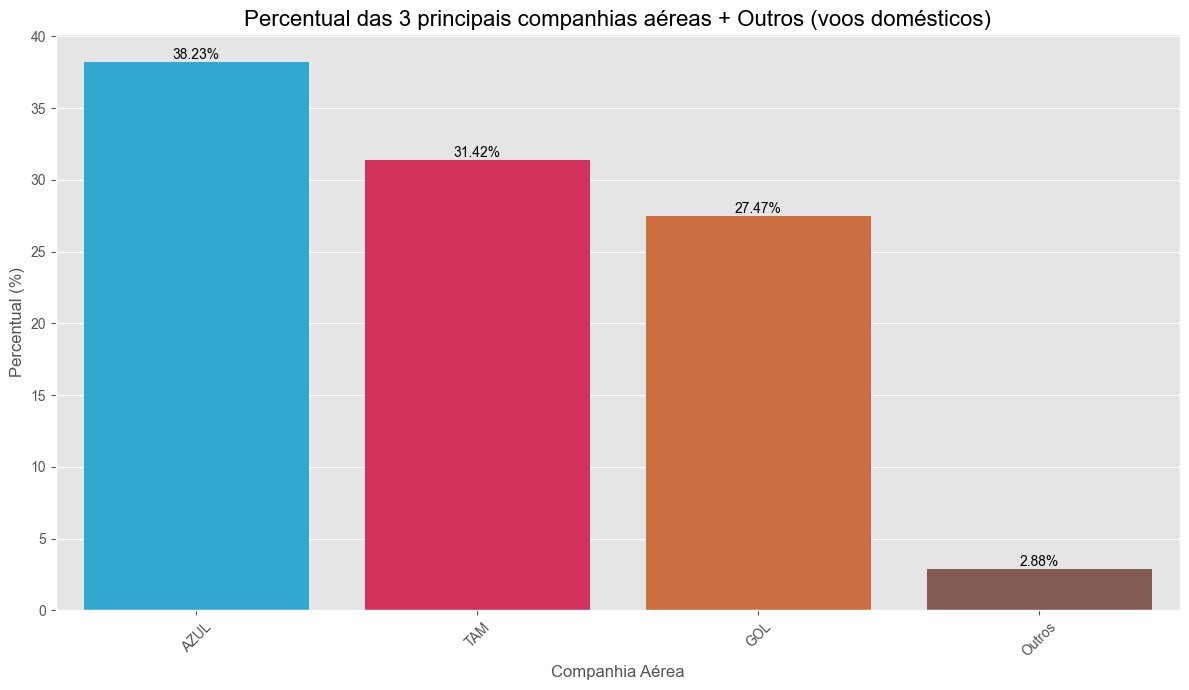

In [122]:
# Filtra voos realizados e domésticos (Brasil-Brasil)
df_domesticos = df_realizados[
    (df_realizados['pais_origem'] == 'BRASIL') &
    (df_realizados['pais_destino'] == 'BRASIL')
]

# Calcula percentual para voos domésticos
percentual_domesticos = df_domesticos['nome_empresas'].value_counts(normalize=True) * 100

# Top 10 empresas e agrupando o restante como 'Outros'
top_10_domesticos = percentual_domesticos.head(3)
outros_domesticos = percentual_domesticos.iloc[3:].sum()

# Concatena usando pd.concat (pandas >=2.0)
df_top10_domesticos = pd.concat([top_10_domesticos, pd.Series({'Outros': outros_domesticos})])

# Gráfico de barras
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=df_top10_domesticos.index, y=df_top10_domesticos.values, palette=colors,
                    hue_order=ordem_empresas)

# Labels com percentual nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('Percentual das 3 principais companhias aéreas + Outros (voos domésticos)', fontsize=16)
plt.ylabel('Percentual (%)')
plt.xlabel('Companhia Aérea')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [144]:
100-2.88

97.12

In [128]:
top10_empresas = (
    df_domesticos['nome_empresas']
    .value_counts()
    .head(3)
)

In [129]:
total_voos_ano_dome = df_domesticos.groupby('ano').size().reset_index(name='total_voos_ano')

In [130]:
total_voos_ano

,ano,total_voos_ano
0,2022,470228
1,2023,733700
2,2024,735253


In [127]:
top10_empresas

nome_empresas
AZUL    741285
TAM     609259
GOL     532732
Name: count, dtype: int64

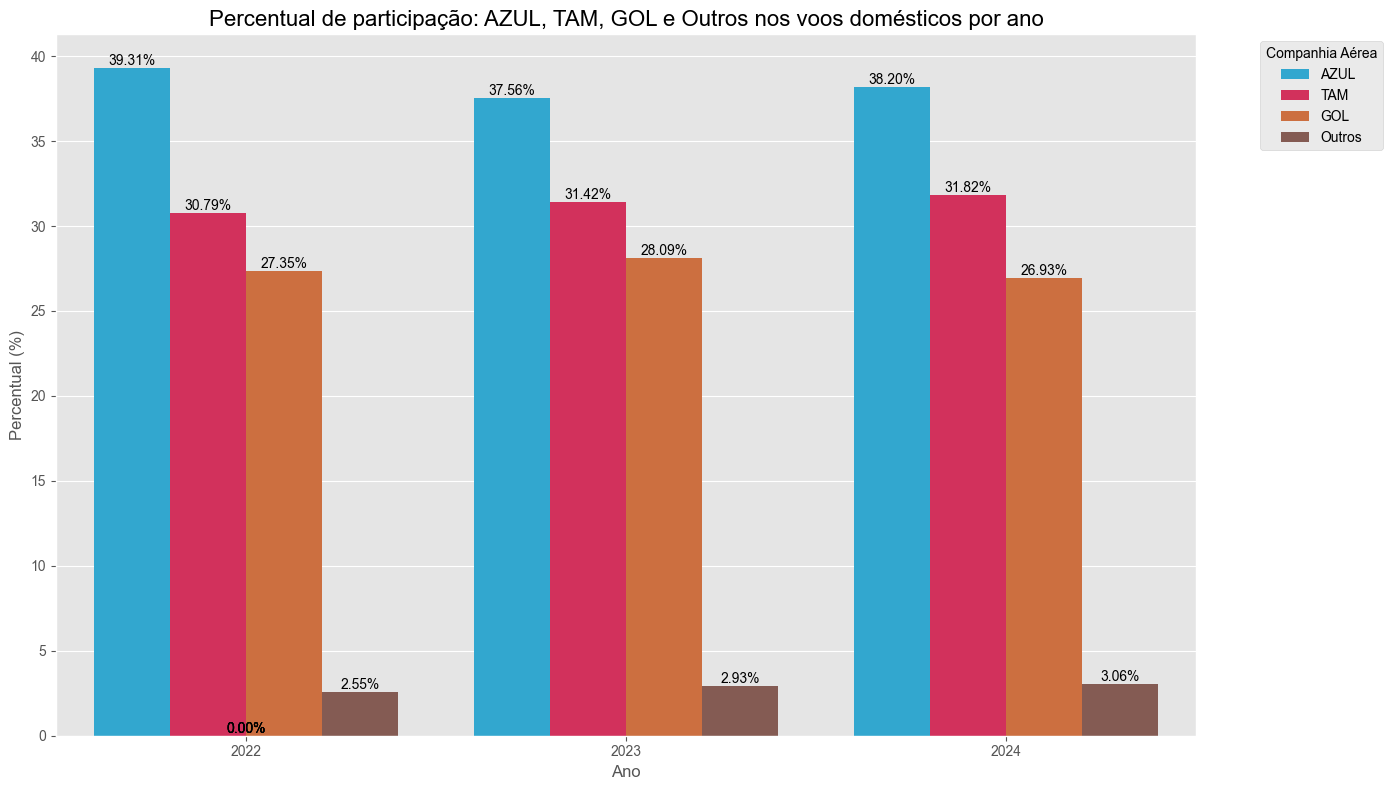

In [119]:
# Passo 1: Conta voos por empresa e ano
df_contagem = df_domesticos.groupby(['ano', 'nome_empresas']).size().reset_index(name='voos')

# Passo 2: Total de voos por ano (para calcular percentual)
total_voos_ano = df_domesticos.groupby('ano').size().reset_index(name='total_voos_ano')

# Merge correto (sem conflitos)
df_percentual_ano = pd.merge(df_contagem, total_voos_ano, on='ano')

# Calcula percentual corretamente
df_percentual_ano['percentual'] = 100 * df_percentual_ano['voos'] / df_percentual_ano['total_voos_ano']

# Identifica as top 10 empresas em termos totais gerais
top10_empresas = (
    df_domesticos['nome_empresas']
    .value_counts()
    .head(3)
    .index
)

# Agrupa empresas menores como 'Outros'
df_percentual_ano['empresa_agrupada'] = df_percentual_ano['nome_empresas'].apply(
    lambda x: x if x in top10_empresas else 'Outros'
)

# Recalcula percentuais agrupando "Outros"
df_final = (
    df_percentual_ano.groupby(['ano', 'empresa_agrupada'], as_index=False)
    .agg({'percentual': 'sum'})
)

# Define a ordem explícita que você deseja
ordem_empresas = ['AZUL', 'TAM', 'GOL', 'Outros']

# Gráfico final com ordem definida
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_final, 
    x='ano', 
    y='percentual', 
    hue='empresa_agrupada',
    hue_order=ordem_empresas,  # ordem personalizada
    palette=colors
)

# Labels com percentual nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('Percentual de participação: AZUL, TAM, GOL e Outros nos voos domésticos por ano', fontsize=16)
plt.ylabel('Percentual (%)')
plt.xlabel('Ano')
plt.legend(title='Companhia Aérea', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [151]:
df = df[df['situacao_voo'] =="REALIZADO"]

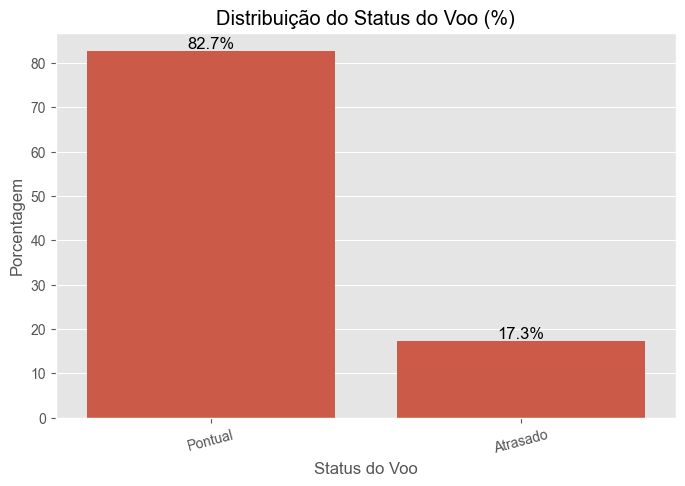

In [164]:
# Recalculando os gráficos corretamente

# Primeiro gráfico: Distribuição da variável status_do_voo em porcentagem
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=df['status_do_voo'].value_counts(normalize=True).index, 
                 y=df['status_do_voo'].value_counts(normalize=True) * 100)

# Adicionando porcentagens
for p in ax.patches:
    percentage = f'{p.get_height():.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=12, color='black')

plt.title("Distribuição do Status do Voo (%)")
plt.xlabel("Status do Voo")
plt.ylabel("Porcentagem")
plt.xticks(rotation=15)
plt.show()


C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\670767331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ano'] = df['ano'].astype(int)  # Garantindo que os anos sejam inteiros


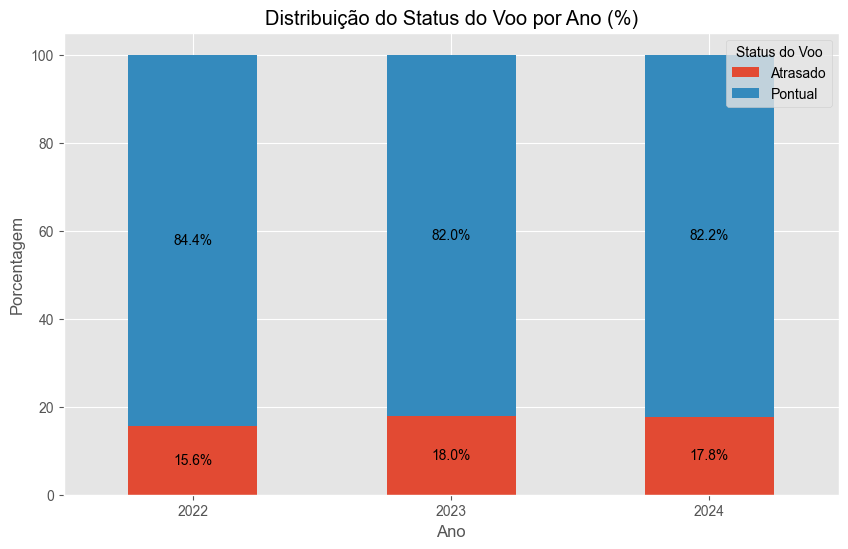

In [166]:
# Segundo gráfico: Distribuição da variável status_do_voo por ano em porcentagem
df['ano'] = df['ano'].astype(int)  # Garantindo que os anos sejam inteiros

# Criando uma tabela com as proporções
df_prop = df.groupby('ano')['status_do_voo'].value_counts(normalize=True).unstack() * 100

# Plotando o gráfico de barras empilhadas
ax = df_prop.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adicionando porcentagens em cima das barras
for container in ax.containers:
    for bar in container:
        if bar.get_height() > 0:  # Evita rótulos em barras vazias
            percentage = f'{bar.get_height():.1f}%'
            ax.annotate(percentage, (bar.get_x() + bar.get_width() / 2., bar.get_y() + bar.get_height() / 2.), 
                         ha='center', va='center', fontsize=10, color='black')

plt.title("Distribuição do Status do Voo por Ano (%)")
plt.xlabel("Ano")
plt.ylabel("Porcentagem")
plt.legend(title="Status do Voo")
plt.xticks(rotation=0)  # Mantendo os anos alinhados corretamente
plt.show()

C:\Users\pedro\AppData\Local\Temp\ipykernel_23204\3248975801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ano'] = df['ano'].astype(int)  # Garantindo que os anos sejam inteiros


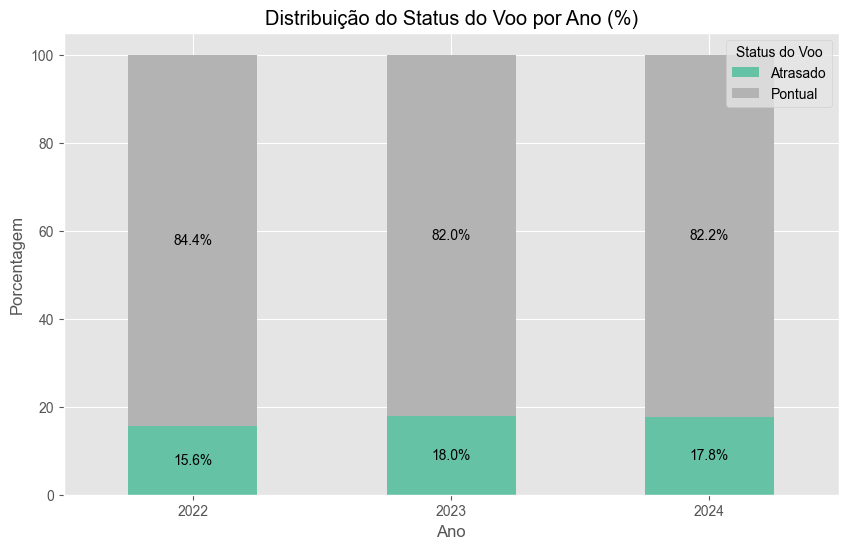

In [165]:
df['ano'] = df['ano'].astype(int)
ax = sns.histplot(data=df, x='ano', hue='status_do_voo', multiple='fill', shrink=0.8, bins=len(df['ano'].unique()))

# Adicionando porcentagens em cima das barras
for p in ax.patches:
    if p.get_height() > 0:  # Evita rótulos em barras vazias
        percentage = f'{100 * p.get_height():.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.), 
                     ha='center', va='center', fontsize=10, color='black')

plt.title("Distribuição do Status do Voo por Ano (%)")
plt.xlabel("Ano")
plt.ylabel("Porcentagem")
plt.legend(title="Status do Voo")
plt.show()

In [ ]:
# Definir o caminho do diretório e do arquivo CSV
diretorio = 'dados_tratados'
nome_arquivo = 'historico_voo_tratados_2019.parquet'
caminho_completo = os.path.join(diretorio, nome_arquivo)

# Verificar se o diretório existe. Se não, criar o diretório
if not os.path.exists(diretorio):
    os.makedirs(diretorio)

# Salvar o DataFrame no arquivo CSV
df.to_parquet(caminho_completo, index=False)

In [116]:
diretorio = 'dados_tratados'
nome_arquivo = 'historico_voo_tratados_2019.parquet'
caminho_completo = os.path.join(diretorio, nome_arquivo)
df.to_parquet(caminho_completo)